<a href="https://colab.research.google.com/github/nuwanc/ml/blob/main/smartbakery.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# to ignore convergence warnings
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('Bakery_Dataset.csv',index_col='Date',parse_dates=True)
df.head()

,Day_of_Week,Holiday,Total_Buns_Produced,Sold_by_5_PM,Sold_by_9_PM,Leftovers_at_9_PM,Waste
Date,,,,,,,
2024-07-01,0,0,40,31,33,7,1
2024-07-02,1,0,40,29,35,5,1
2024-07-03,2,0,40,35,40,0,0
2024-07-04,3,0,40,27,36,4,0
2024-07-05,4,0,55,35,53,2,0


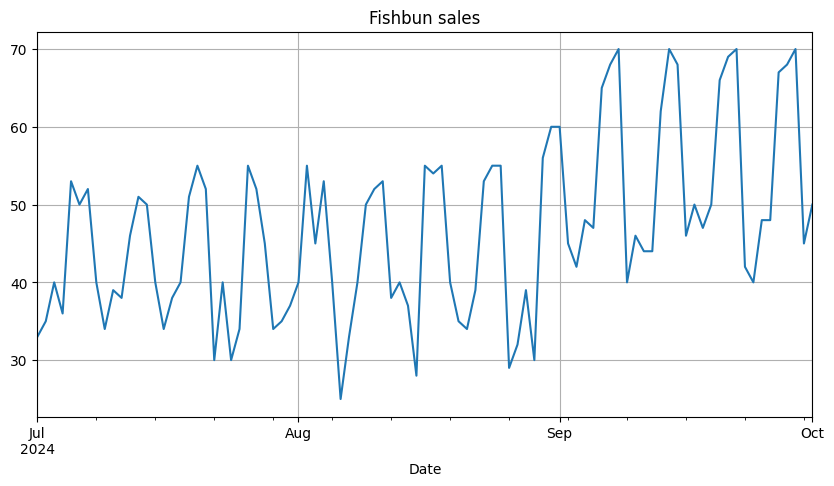

In [2]:
df["Sold_by_9_PM"].plot(grid=True,figsize=(10,5), title = "Fishbun sales" )
plt.show()

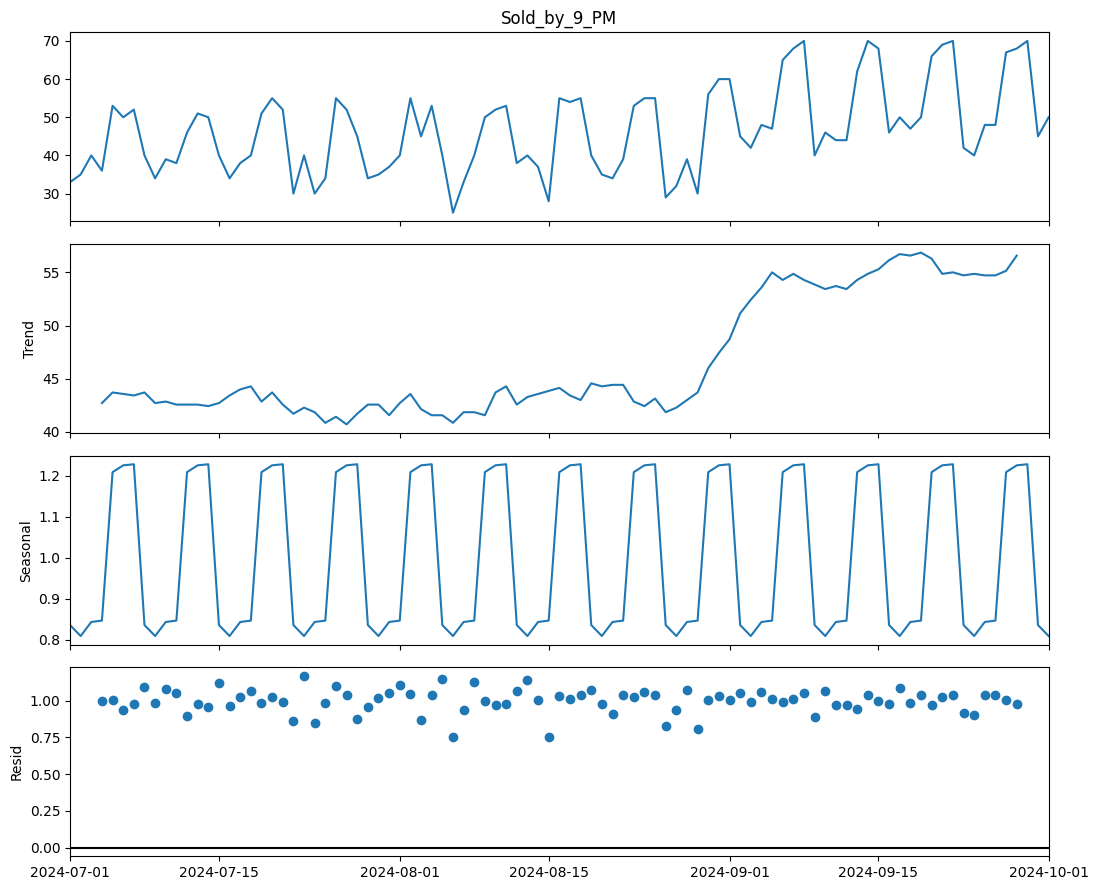

In [14]:
from pylab import rcParams
rcParams['figure.figsize'] = 11, 9

import statsmodels.api as sm
decomposition = sm.tsa.seasonal_decompose(df['Sold_by_9_PM'],
                                         model = 'multiplicative'
                                         )
fig = decomposition.plot()
plt.show()

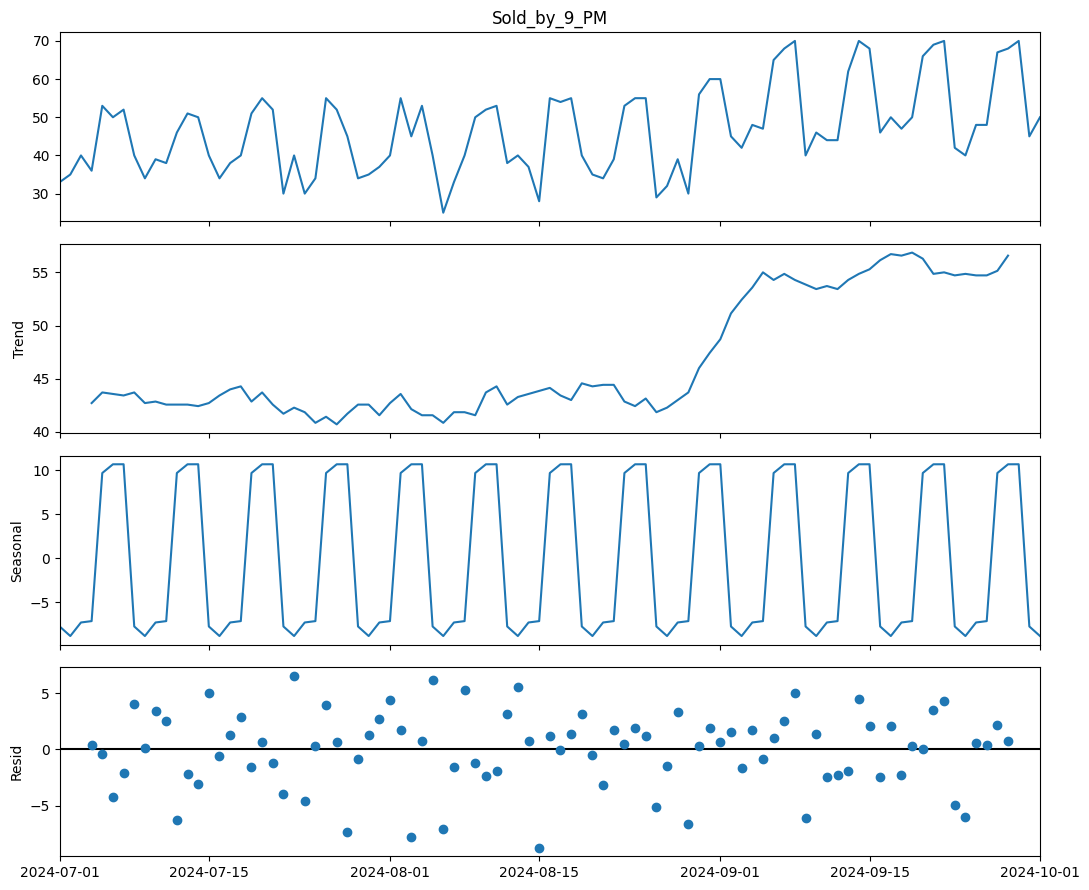

In [15]:
decomposition = sm.tsa.seasonal_decompose(df['Sold_by_9_PM'],
                                         model = 'additive',
                                         )
fig = decomposition.plot()
plt.show()

In [5]:
from statsmodels.tsa.stattools import adfuller

def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)


from statsmodels.tsa.stattools import kpss
def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c', nlags="auto")
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)


In [6]:
adf_test(df['Sold_by_9_PM'])

Results of Dickey-Fuller Test:
Test Statistic                 -0.548519
p-value                         0.882196
#Lags Used                      9.000000
Number of Observations Used    83.000000
Critical Value (1%)            -3.511712
Critical Value (5%)            -2.897048
Critical Value (10%)           -2.585713
dtype: float64


In [7]:
kpss_test(df['Sold_by_9_PM'])

Results of KPSS Test:
Test Statistic           1.175692
p-value                  0.010000
Lags Used                4.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


<ipython-input-5-3ebb5df2b4a4>:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpsstest = kpss(timeseries, regression='c', nlags="auto")


In [8]:
def obtain_adf_kpss_results(timeseries, max_d):
    """ Build dataframe with ADF statistics and p-value for time series after applying difference on time series

    Args:
        time_series (df): Dataframe of univariate time series
        max_d (int): Max value of how many times apply difference

    Returns:
        Dataframe showing values of ADF statistics and p when applying ADF test after applying d times
        differencing on a time-series.

    """

    results=[]

    for idx in range(max_d):
        adf_result = adfuller(timeseries, autolag='AIC')
        kpss_result = kpss(timeseries, regression='c', nlags="auto")
        timeseries = timeseries.diff().dropna()
        if adf_result[1] <=0.05:
            adf_stationary = True
        else:
            adf_stationary = False
        if kpss_result[1] <=0.05:
            kpss_stationary = False
        else:
            kpss_stationary = True

        stationary = adf_stationary & kpss_stationary

        results.append((idx,adf_result[1], kpss_result[1],adf_stationary,kpss_stationary, stationary))

    # Construct DataFrame
    results_df = pd.DataFrame(results, columns=['d','adf_stats','p-value', 'is_adf_stationary','is_kpss_stationary','is_stationary' ])

    return results_df

In [11]:
obtain_adf_kpss_results(df['Sold_by_9_PM'], 3)

<ipython-input-8-f96ad231de31>:18: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(timeseries, regression='c', nlags="auto")
<ipython-input-8-f96ad231de31>:18: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(timeseries, regression='c', nlags="auto")
<ipython-input-8-f96ad231de31>:18: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(timeseries, regression='c', nlags="auto")


,d,adf_stats,p-value,is_adf_stationary,is_kpss_stationary,is_stationary
0,0,0.882196,0.01,False,False,False
1,1,0.000060,0.10,True,True,True
2,2,0.001134,0.10,True,True,True


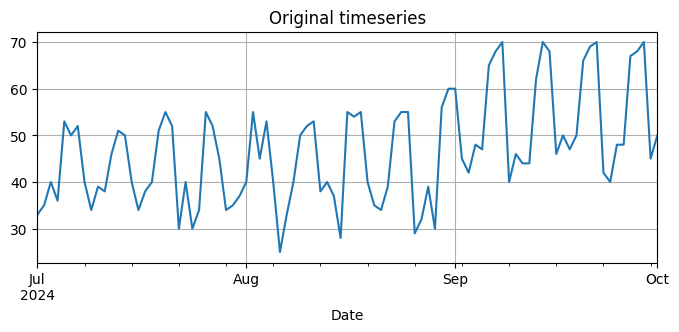

In [12]:
df['Sold_by_9_PM'].plot(grid=True,figsize=(8,3), title = "Original timeseries" )
plt.show()

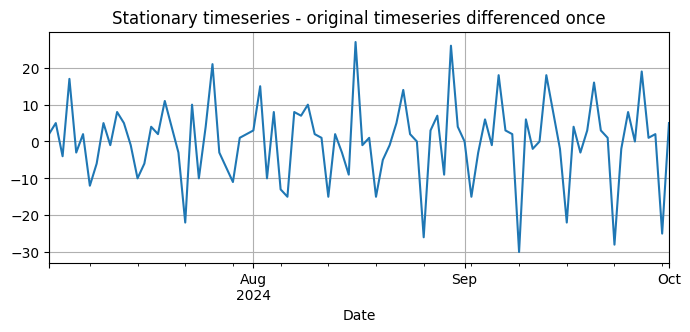

In [13]:
df['Sold_by_9_PM'].diff().dropna().plot(grid=True,figsize=(8,3), title = "Stationary timeseries - original timeseries differenced once" )
plt.show()

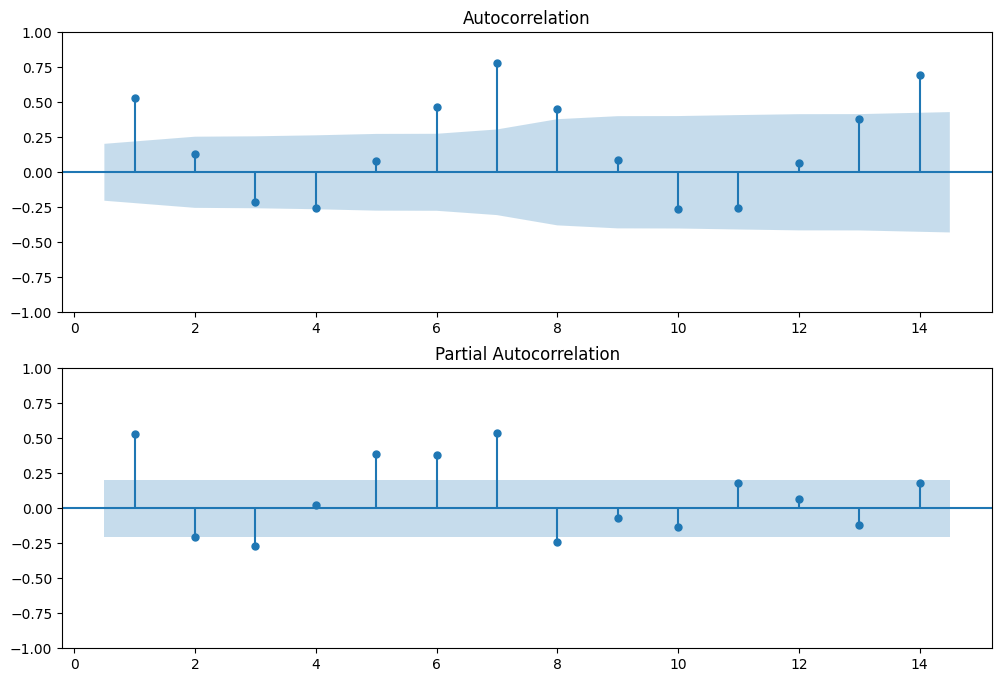

In [16]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Create figure
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))

plot_acf(df['Sold_by_9_PM'],lags=14, zero=False, ax=ax1)

plot_pacf(df['Sold_by_9_PM'],lags=14, zero=False, ax=ax2)

plt.show()

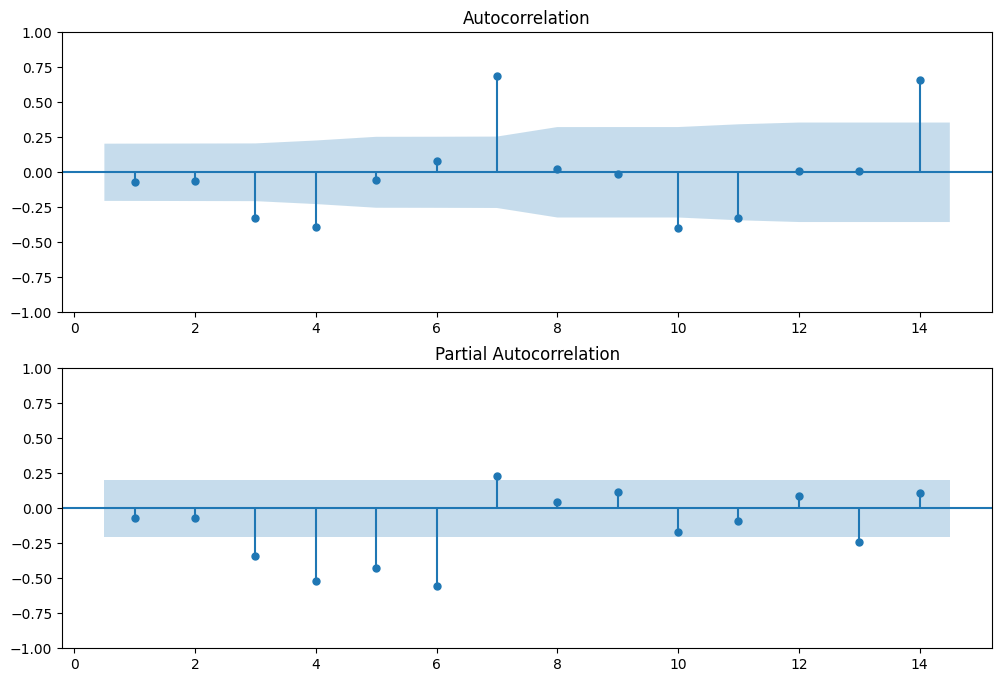

In [17]:
# Create figure
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))

plot_acf(df['Sold_by_9_PM'].diff().dropna(),lags=14, zero=False, ax=ax1)

plot_pacf(df['Sold_by_9_PM'].diff().dropna(),lags=14, zero=False, ax=ax2)

plt.show()

In [18]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# just an example
model = SARIMAX(df['Sold_by_9_PM'], order=(1,1,1), freq='D')
results = model.fit()
# statistics of the model
results.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           Sold_by_9_PM   No. Observations:                   93
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -338.507
Date:                Sat, 05 Oct 2024   AIC                            683.014
Time:                        15:47:42   BIC                            690.579
Sample:                    07-01-2024   HQIC                           686.067
                         - 10-01-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4479      0.164      2.731      0.006       0.126       0.769
ma.L1         -0.9403      0.061    -15.502      0.000      -1.059      -0.821
sigma2        90.6479     17.616      5.146      0.000      56.121     125.175
===================================================================================
Ljung-Box (L1) (Q):                   1.00   Jarque-Bera (JB):                 1.01
Prob(Q):                              0.32   Prob(JB):                         0.60
Heteroskedasticity (H):               2.10   Skew:                            -0.18
Prob(H) (two-sided):                  0.04   Kurtosis:                         2.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [20]:
# Create empty list to store search results
order_aic_bic=[]

# Loop over p values from 0-6
for p in range(7):
  # Loop over q values from 0-6
    for q in range(7):
      	# create and fit ARMA(p,q) model
        model = SARIMAX(df['Sold_by_9_PM'], order=(p,1,q),freq="D") #because adf test showed that d=1
        results = model.fit()

        # Append order and results tuple
        order_aic_bic.append((p,q,results.aic, results.bic))

# Construct DataFrame from order_aic_bic
order_df = pd.DataFrame(order_aic_bic,
                        columns=['p','q','AIC','BIC'])

# Print order_df in order of increasing AIC
order_df.sort_values('AIC')

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dat

,p,q,AIC,BIC
46,6,4,580.320974,608.060649
48,6,6,582.160696,614.943948
33,4,5,587.326131,612.544017
47,6,5,588.510665,618.772128
45,6,3,589.449974,614.667860
34,4,6,589.743695,617.483369
41,5,6,591.412384,621.673847
42,6,0,596.552431,614.204951
20,2,6,596.762690,619.458788
43,6,1,596.868068,617.042377


In [21]:
# Print order_df in order of increasing BIC
order_df.sort_values('BIC')

,p,q,AIC,BIC
46,6,4,580.320974,608.060649
33,4,5,587.326131,612.544017
42,6,0,596.552431,614.204951
45,6,3,589.449974,614.667860
48,6,6,582.160696,614.943948
43,6,1,596.868068,617.042377
34,4,6,589.743695,617.483369
24,3,3,600.328593,617.981113
47,6,5,588.510665,618.772128
18,2,4,601.545477,619.197997


In [30]:
import numpy as np
arima_model = SARIMAX(df['Sold_by_9_PM'], order=(6,1,4))
# fit model
arima_results = arima_model.fit()

# Calculate the mean absolute error from residuals
mae = np.mean(np.abs(arima_results.resid))

# Print mean absolute error
print('MAE: %.3f' % mae)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 4.214


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [31]:
df['Sold_by_9_PM'].describe()

,Sold_by_9_PM
count,93.000000
mean,46.709677
std,11.342092
min,25.000000
25%,39.000000
50%,46.000000
75%,53.000000
max,70.000000


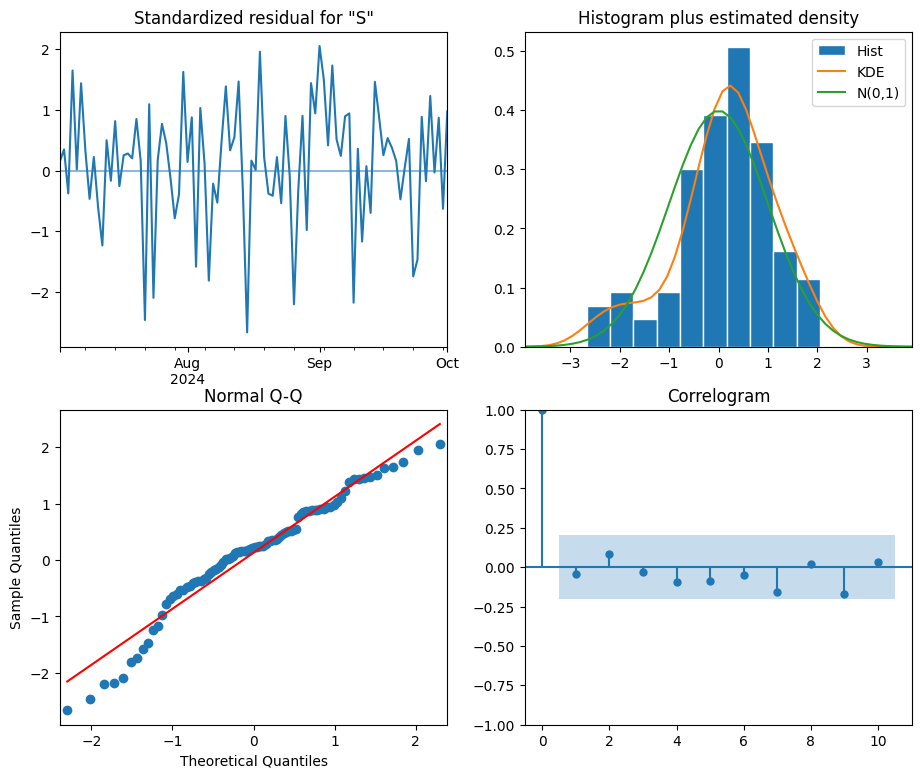

In [32]:
# Create the 4 diagostics plots using plot_diagnostics method
arima_results.plot_diagnostics()
plt.show()

In [35]:
!pip install pmdarima
import pmdarima as pm

# Create auto_arima model
model1 = pm.auto_arima(df['Sold_by_9_PM'], #time series
                      seasonal=True, # is the time series seasonal
                      m=7, # the seasonal period - one week?
                      d=1, # non-seasonal difference order
                      D=1, # seasonal difference order
                 	  max_p=6, # max value of p to test
                      max_q=6, # max value of p to test
                      max_P=6, # max value of P to test
                      max_Q=6, # max value of Q to test
                      information_criterion='aic', # used to select best mode
                      trace=True, # prints the information_criterion for each model it fits
                      error_action='ignore', # ignore orders that don't work
                      stepwise=True, # apply an intelligent order search
                      suppress_warnings=True)

# Print model summary
print(model1.summary())

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 20.3 MB/s eta 0:00:00
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[7]             : AIC=513.208, Time=0.42 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=594.332, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=547.890, Time=0.08 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=513.128, Time=0.18 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=555.077, Time=0.05 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=512.929, Time=0.17 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=526.094, Time=0.09 sec
 ARIMA(0,1,1)(2,1,1)[7]             : AIC=514.633, Time=0.32 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=514.505, Time=0.58 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=512.580, Time=0.19 sec
 ARIMA(0,1,1)(0,1,3)[7]             : AIC=514.491, Time=0.47 sec
 ARIMA(0,1,1)(1,1,3)[7]             : AIC=516.560, Time=0.62 sec
 ARIMA(0,1,0)(0,1,2)[7]             : AIC=549.389, Time=0.14 sec
 ARIMA(1,1,1)(0,1,2)[7]            

In [38]:
sarima_02_model = SARIMAX(df['Sold_by_9_PM'], order=(6,1,4), seasonal_order=(1,1,2,7))
sarima_02_results = sarima_02_model.fit()

# Calculate the mean absolute error from residuals
mae = np.mean(np.abs(sarima_02_results.resid))

# Print mean absolute error
print('MAE: %.3f' % mae)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 4.377


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
